# Tabula Muris Senis reference

July 9, 2021

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

## Make count matrix .rds objects

* Data downloaded from: https://figshare.com/articles/dataset/Processed_files_to_use_with_scanpy_/8273102
* .mtx, barcodes.csv, genes.csv, and hvg.csv were extracted from published .h5ad files using scanpy prior to loading into R

In [2]:
## FACS
facs_exp = readMM('data/tms_counts_facs.MM.mtx') %>% t()
facs_cells = read.csv('data/tms_barcodes_facs.csv', header = F)[,1]
facs_genes = read.csv('data/tms_genes_facs.csv', header = F)[,1]
rownames(facs_exp) = facs_genes
colnames(facs_exp) = facs_cells
dim(facs_exp)
facs_exp[1:5, 1:5]
saveRDS(facs_exp, 'data/tms_counts_facs.rds')

[1]  22966 110824

5 x 5 sparse Matrix of class "dgTMatrix"
              A10_B000497_B009023_S10.mm10-plus-0-0
0610005C13Rik                                     .
0610007C21Rik                                    15
0610007L01Rik                                     .
0610007N19Rik                                     .
0610007P08Rik                                     .
              A10_B000756_B007446_S10.mm10-plus-0-0
0610005C13Rik                                     .
0610007C21Rik                                   815
0610007L01Rik                                     4
0610007N19Rik                                     .
0610007P08Rik                                   236
              A10_B000802_B009022_S10.mm10-plus-0-0
0610005C13Rik                                     .
0610007C21Rik                                     .
0610007L01Rik                                     .
0610007N19Rik                                     .
0610007P08Rik                                   125
              A10_B0009

## Build FACS reference

Read in metadata

In [3]:
metadata_facs = read.csv('data/tms_metadata_facs.csv')

cols_to_keep = c('index' ,'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 
                 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes')
metadata_facs = metadata_facs[ , cols_to_keep]

Normalize data (log CP10k)

In [4]:
facs_exp_norm = singlecellmethods::normalizeData(facs_exp, 1e4, 'log')

Subset by variable genes

In [5]:
hvgs_facs = read.csv('data/tms_metadata_facs_hvg.csv') # use same variable genes as original authors
hvgs_facs$index = as.character(hvgs_facs$index)
hvgs_facs = hvgs_facs[which(hvgs_facs$highly_variable == 'True'), ]

Scale genes

In [6]:
facs_exp_vargenes = facs_exp_norm[hvgs_facs$index, ]
vargenes_means_sds = tibble(symbol = hvgs_facs$index, mean = Matrix::rowMeans(facs_exp_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(facs_exp_vargenes, vargenes_means_sds$mean)
facs_exp_scaled = singlecellmethods::scaleDataWithStats(facs_exp_vargenes, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

PCA embedding

In [7]:
set.seed(1)
# Run SVD, save gene loadings
s = irlba(facs_exp_scaled, nv = 50)
Z_pca_facs = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

Harmony

In [8]:
unique(metadata_facs$cell_ontology_class) %>% length()

[1] 120

Harmony/Symphony compression

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony converged after 14 iterations

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



     user    system   elapsed 
 6585.531 12733.014  1534.501 

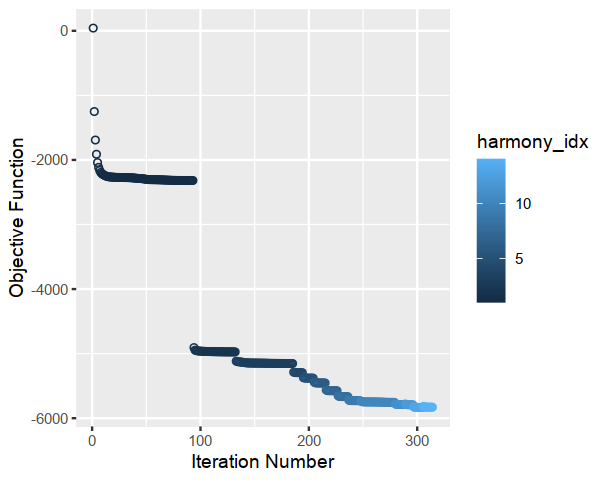

In [9]:
fig.size(4, 5)
set.seed(1)
# Harmonize the reference
ptm <- proc.time()
facs_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_facs), ## PCA embedding matrix of cells
        meta_data = metadata_facs, ## dataframe with cell labels
        theta = c(2),            ## cluster diversity enforcement
        vars_use = c('mouse.id'),   ## variable to integrate out
        nclust = 300,            ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,    ## return the full Harmony model object
        do_pca = FALSE,          ## do not recompute PCs
        plot_convergence = TRUE
)

# Compress Harmony obj into a Symphony reference
reference_facs = buildReferenceFromHarmonyObj(
                facs_harmObj,            # output object from HarmonyMatrix()
                metadata_facs,
                vargenes_means_sds,     # gene names, means, and std devs for scaling
                loadings,               # genes x PCs
                verbose = TRUE, 
                do_umap = FALSE )

proc.time() - ptm

UMAP embedding

In [10]:
# Run UMAP using Seurat default parameters
set.seed(1)
facs_umap = uwot::umap(t(reference_facs$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
            metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1, # for reproducibility
            min_dist = 0.3, n_threads = 4, ret_model = TRUE)

In [11]:
# Save UMAP model
save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/TMS_facs_uwot_model'
model = uwot::save_uwot(facs_umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
save_uwot_path = '../pre-built_references/TMS_facs_uwot_model'
reference_facs$save_uwot_path = save_uwot_path

# Save UMAP coordinates
colnames(facs_umap$embedding) = c('UMAP1', 'UMAP2')
reference_facs$umap = facs_umap

Warning message:
“invalid uid value replaced by that for user 'nobody'”


Save Symphony reference

In [12]:
saveRDS(reference_facs, '../pre-built_references/TMS_facs_reference.rds')

In [13]:
reference_facs = readRDS('../pre-built_references/TMS_facs_reference.rds')

Plot reference

In [14]:
# Visualize reference
library(RColorBrewer)
tms.colors = c(brewer.pal(name="Dark2", n = 8), brewer.pal(name="Paired", n = 12),
            brewer.pal(name="Set1", n = 9), brewer.pal(name="Set2", n = 8),
            brewer.pal(name='Accent', n = 7), brewer.pal(name='Set3', n = 12))

umap_labels = cbind(reference_facs$meta_data, reference_facs$umap$embedding)

Plot by donor

null device 
          1

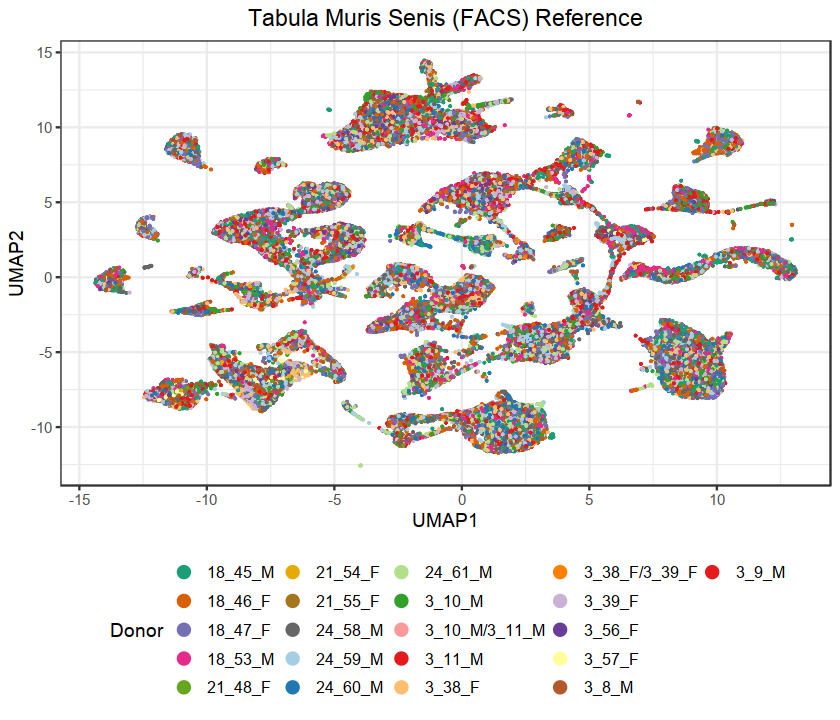

In [15]:
# Plot UMAP visualization
fig.size(6, 7)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = mouse.id)) +
    geom_point_rast(size = 0.3) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Donor') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=9)) + 
    scale_colour_manual(values = tms.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3)))
print(p)
dev.off()
p

Plot by tissue

Adding missing grouping variables: `tissue`



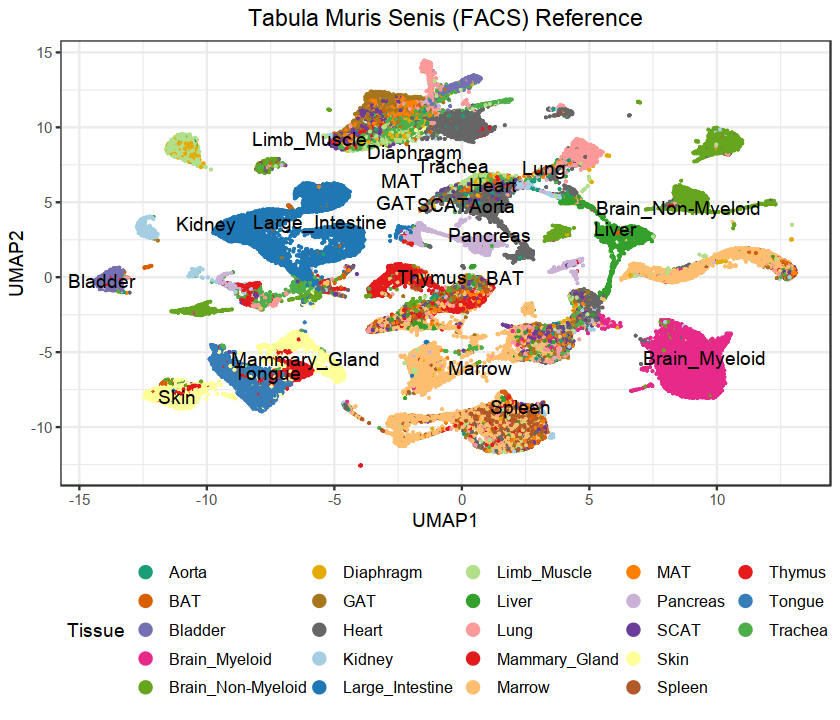

In [16]:
# Plot UMAP visualization
fig.size(6, 7)

# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
    dplyr::group_by(tissue) %>% # group_by_at takes variable column name
    dplyr::select(UMAP1, UMAP2) %>% 
    dplyr::summarize_all(median)

p_tissue = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = tissue)) +
    geom_point_rast(size = 0.3) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Tissue') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=9)) + 
    scale_colour_manual(values = tms.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3)))
        
p_tissue = p_tissue + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = tissue), 
                    segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.01, color = 'black')
p_tissue

Plot by cell ontology class

Adding missing grouping variables: `cell_ontology_class`



null device 
          1

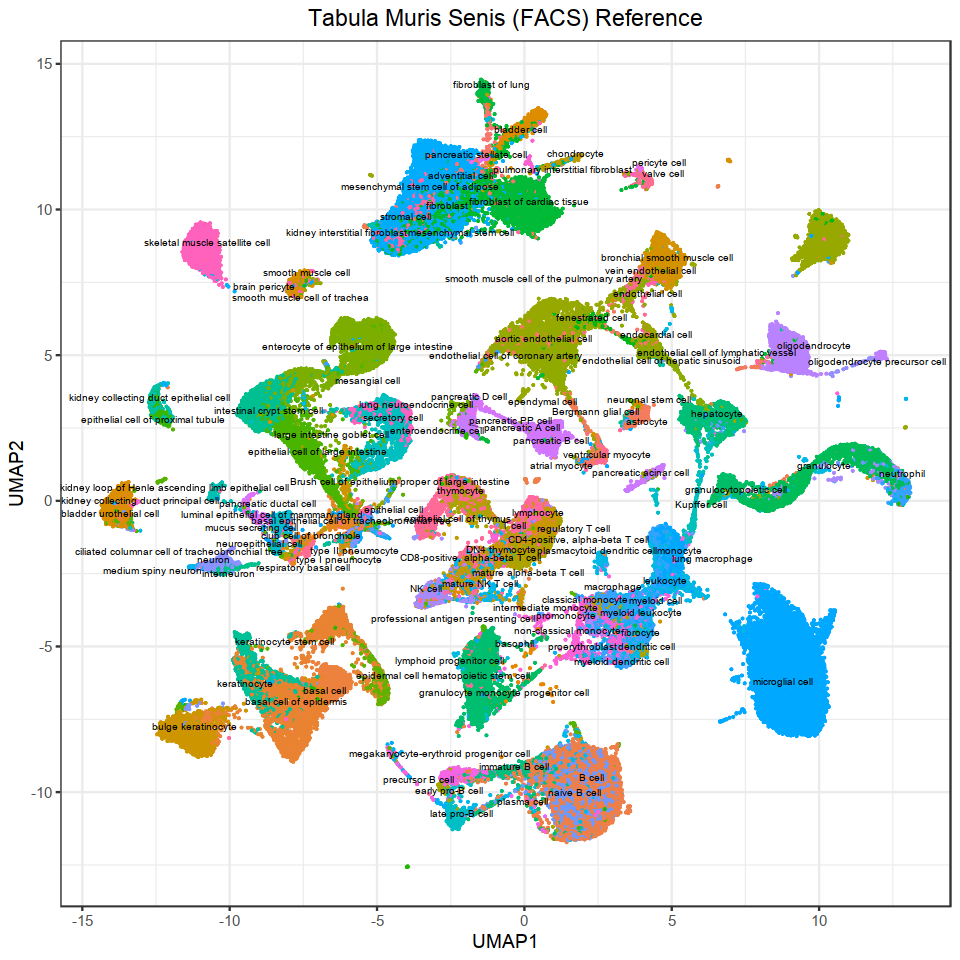

In [17]:
# Plot UMAP visualization
fig.size(8, 8)

# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
    dplyr::group_by(cell_ontology_class) %>% # group_by_at takes variable column name
    dplyr::select(UMAP1, UMAP2) %>% 
    dplyr::summarize_all(median)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_ontology_class)) +
    geom_point_rast(size = 0.3) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Cell ontology class') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=9)) + 
    guides(colour = guide_legend(override.aes = list(size = 3)))

p = p + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = cell_ontology_class), 
                    size = 2, segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.01, color = 'black', max.overlaps = 40)

print(p)
dev.off()
p

## Map query

In [18]:
## Read in Baron mouse data
mouse = readRDS('data/baron-mouse.rds')

mouse_exp = Matrix(mouse@assays[['data']][['counts']], sparse = TRUE)
mouse_exp = as(mouse_exp, "dgCMatrix")
mouse_metadata = mouse@colData

In [19]:
mouse_exp %>% dim()
colnames(mouse_metadata)[1] = 'donor'
mouse_metadata$cell_type = mouse_metadata$cell_type1 %>%
        plyr::mapvalues(from = c('quiescent_stellate', 'macrophage', 'immune_other', 'activated_stellate', 'B_cell', 'T_cell'),
                         to = c('stellate', 'immune', 'immune', 'stellate', 'immune', 'immune'))
mouse_metadata = as.data.frame(mouse_metadata)[ ,c('donor', 'cell_type1', 'total_features', 'cell_type')]

[1] 14878  1886

In [20]:
query = mapQuery(mouse_exp, metadata_query = mouse_metadata, 
                 ref_obj = reference_facs, vars = 'donor', do_normalize = TRUE, do_umap = TRUE)

Normalizing

Scaling and synchronizing query gene expression

Found 1970 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [21]:
reference_facs$vargenes$symbol %>% length()

[1] 2855

Looks like only 1970 of the 2855 reference variable genes are named using the same gene symbol in the query. Therefore, the mapping is likely not ideal and so we won't go too deep into accuracy metrics.

## Plot query

In [22]:
library(patchwork)
source('../pre-built_references/colors.R')

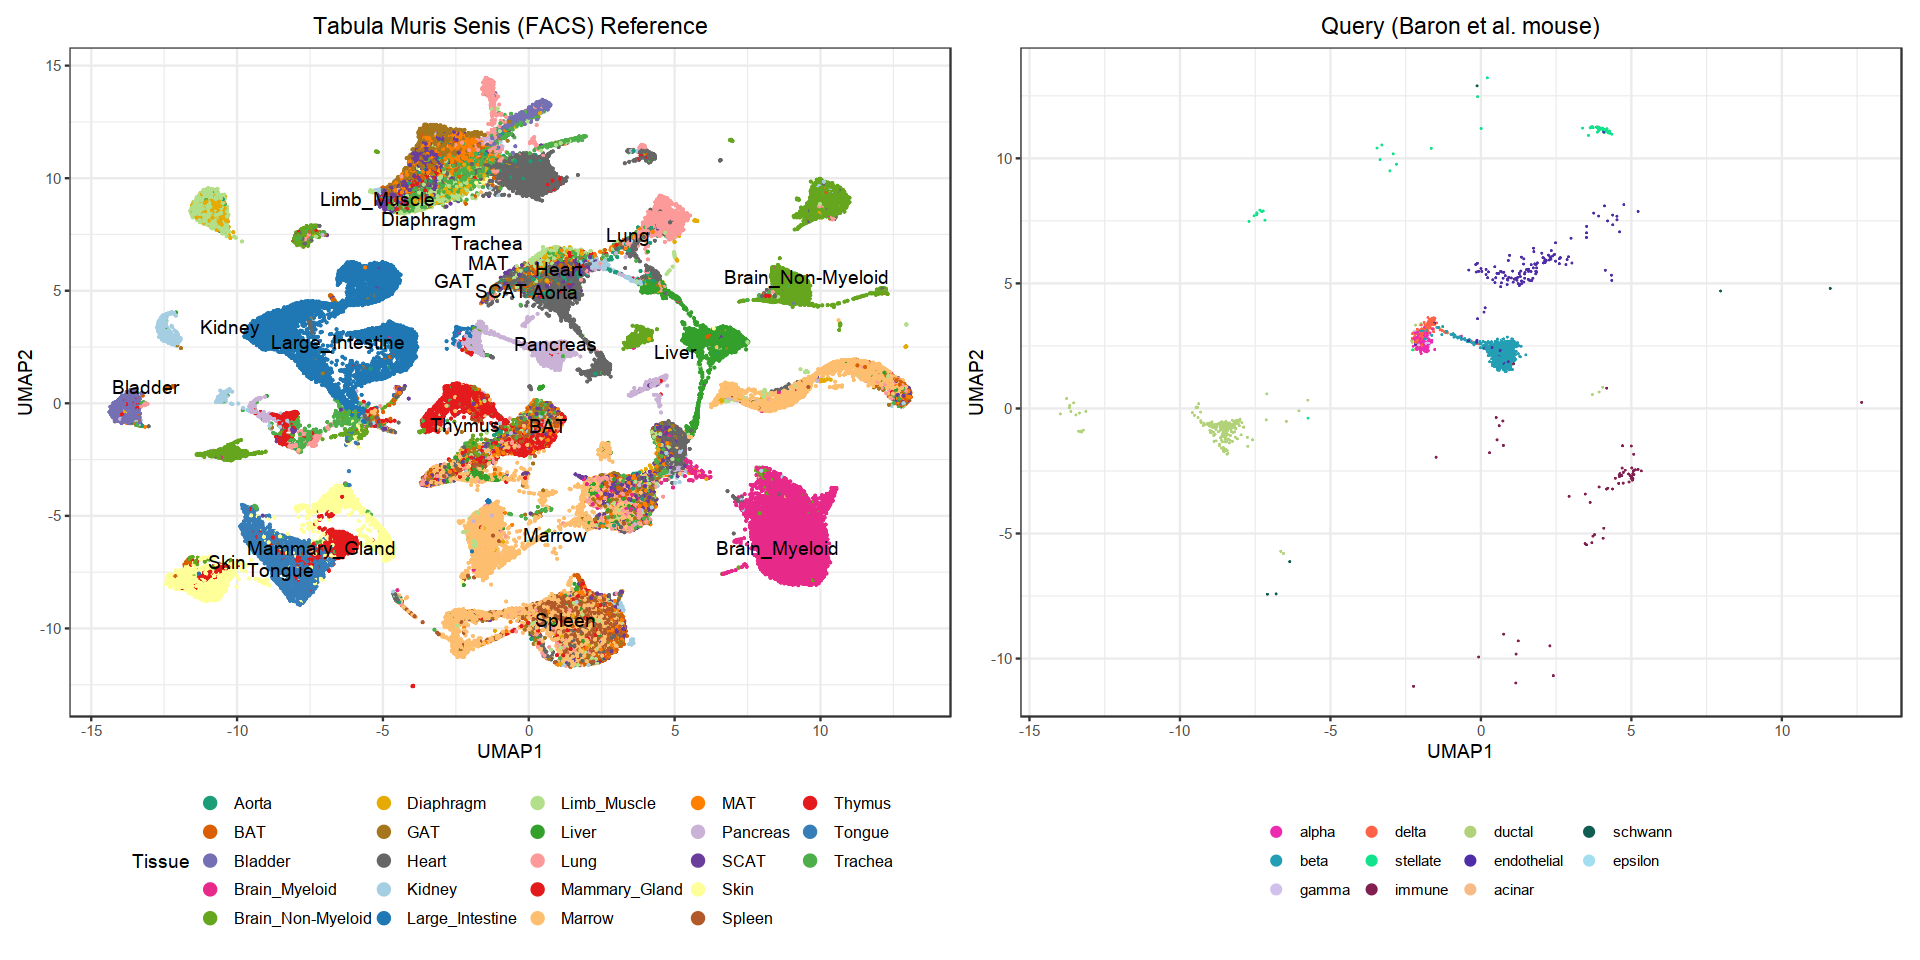

In [23]:
umap_combined_labels = cbind(query$meta_data, query$umap)
fig.size(8, 16)
q = umap_combined_labels %>%
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.6, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query (Baron et al. mouse)', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
    scale_colour_manual(values = pancreas_colors) +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    theme(strip.text.x = element_text(size=13))
p_tissue + q

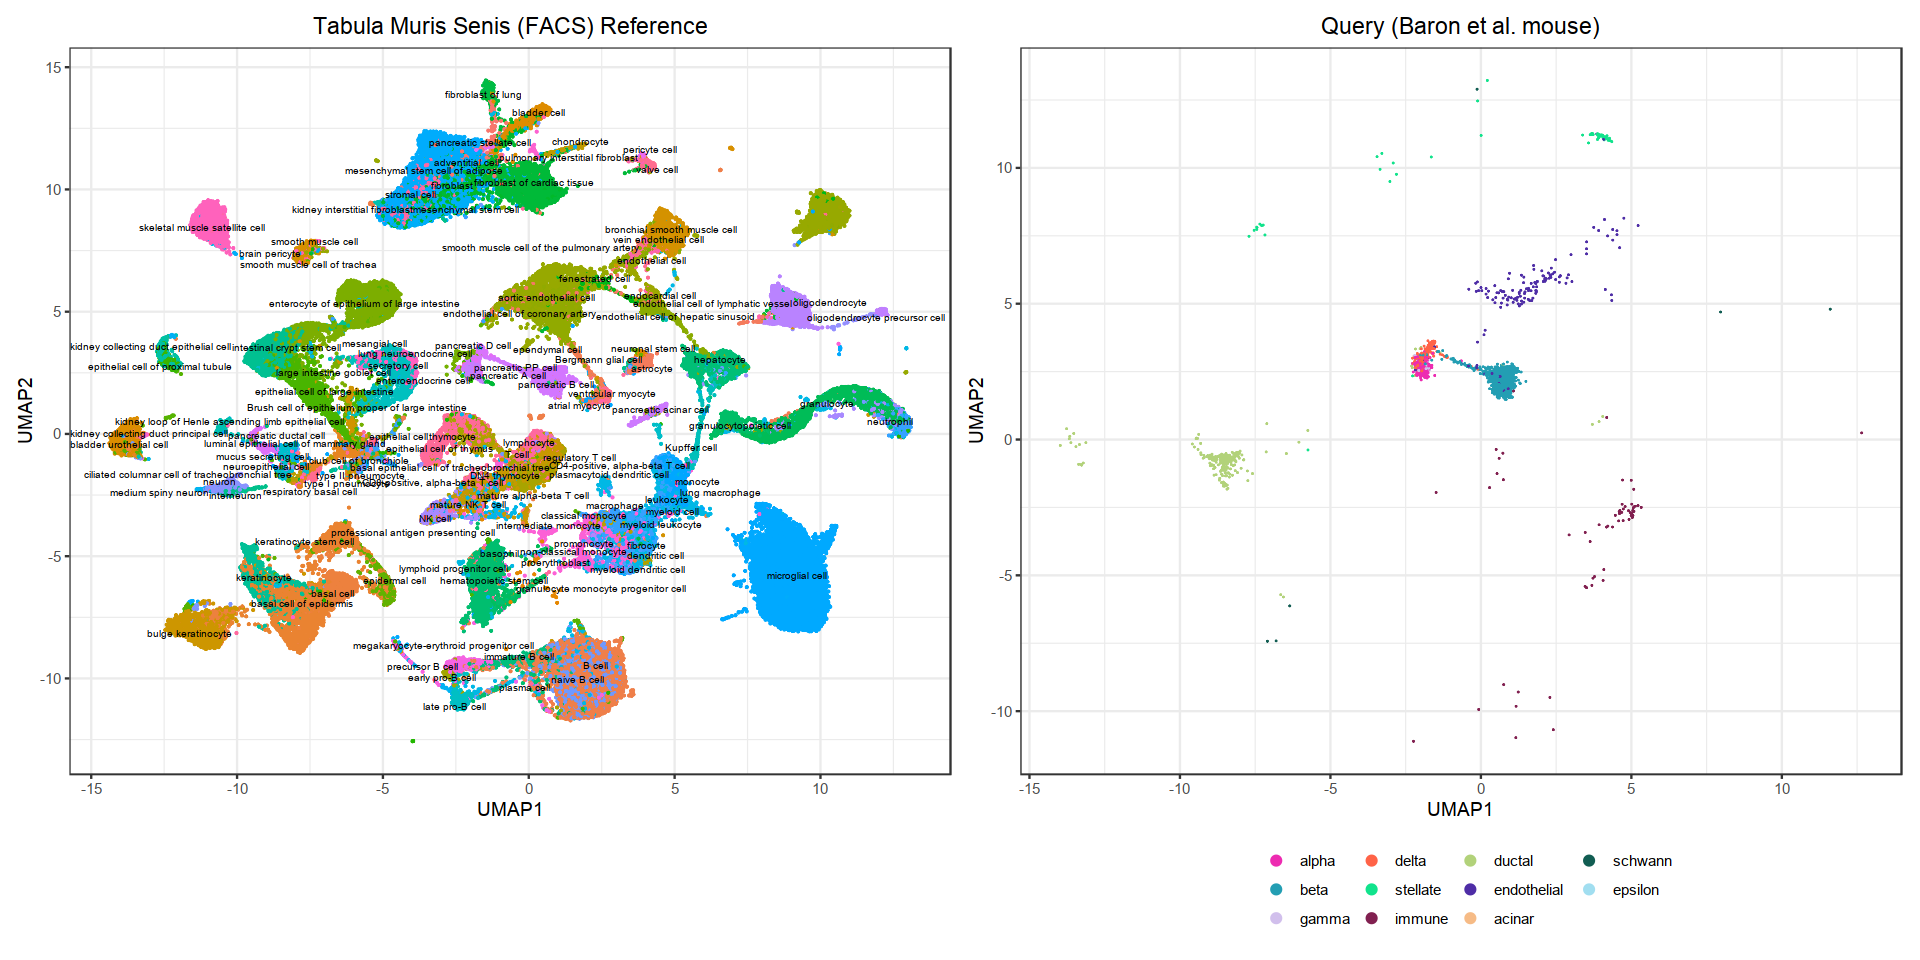

In [24]:
fig.size(8, 16)
p + q

# All done!

In [25]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggthemes_4.2.4          patchwork_1.1.1         ggrepel_0.9.1          
 [4] ggpubr_0.4.0            ggrastr_0.2.3           RColorBrewer_1.1-2     
 [7] pheatmap_1.0.12         biomaRt_2.46.3          symphony_1.0           
[10] SeuratObject_4.0.1      Seurat